In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import random
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torch
import pandas as pd
import time
from utils import *
from sklearn.preprocessing import MultiLabelBinarizer

cwd = os.getcwd()

#Read training image names and labels into pandas dataframe
df = pd.read_csv('train.csv')

labels = df['Target'].values

#Convert labels to a format MultiLabelBinarizer() can use
#ex. "3 5 7" -> "3,5,7"
temp = []
for i in labels:
    temp.append( i.replace(" ", ",").split(','))

#Transform labels from strings to multilabel encoding
#ex. If 7 total classes: "3, 5, 7" -> [0 0 1 0 1 0 1]
trans = MultiLabelBinarizer()
multi_labels = trans.fit_transform(temp)


class CustomDatasetFromImages():
    def __init__(self, path, flip, labels):
        
        #flip images, true or false
        self.flip = flip
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv('train.csv', header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[1:, 0])
        # Second column is the labels
        self.label_arr = labels
        self.path = path
        
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        
        #Get image name from the pandas df
        single_image_name = self.path + self.image_arr[index]
        
        #Load image channels
        img_as_img1 = Image.open(single_image_name+'_blue.png')
        img_as_img2 = Image.open(single_image_name+'_yellow.png')
        img_as_img3 = Image.open(single_image_name+'_green.png')
        
        #Randomly flip images
        tf = transforms.RandomVerticalFlip(p=1)
        if self.flip and (random.uniform(0, 1) > 0.5):
            img_as_img1 = tf(img_as_img1)
            img_as_img2 = tf(img_as_img2)
            img_as_img3 = tf(img_as_img3)
            
      
        # Transform image to tensor
        img_as_tensor1 = self.to_tensor(img_as_img1)
        img_as_tensor2 = self.to_tensor(img_as_img2)
        img_as_tensor3 = self.to_tensor(img_as_img3)
        image = torch.cat((img_as_tensor1.reshape(1,512,512), img_as_tensor2.reshape(1,512,512)), dim=0)
        image = torch.cat((image, img_as_tensor3.reshape(1,512,512)), dim=0)
        # Get label(class) of the image based on the cropped pandas column
        
        #Normalize tensor. Mean and std chosen based on pytorch transfer learning tutorial
        tf = transforms.Normalize(mean=[0.485],std=[0.229])
        image = tf(image)
        
        single_image_label = self.label_arr[index]

        return (image, single_image_label)

    def __len__(self):
        return self.data_len

#Build data loader
batch_size = 16
img_dir = cwd + '/Train/'
train = CustomDatasetFromImages(img_dir,flip=False,labels=multi_labels)
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)

#Initialize GPU settings and choose device, optimized for speed
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True

#Load pretrained model from PyTorch library
pretrained_model = torchvision.models.resnet50(pretrained=True)
#model_conv = models.alexnet(pretrained=True)
#model_conv = models.squeezenet1_0(pretrained=True)
#model_conv = models.vgg16(pretrained=True)
#model_conv = models.densenet161(pretrained=True)
#model_conv = models.inception_v3(pretrained=True)

#Freeze all pretrained model layers, prevents updating weights during training.
#This allows for utilization of pretrained model's ability to extract features
for param in pretrained_model.parameters():
    param.requires_grad = False

#Add new fully connected layer(s) to the bottom of pretrained model, and build.
#Weights will be updated during training, building the decision making ability of the new model.
num_ftrs = pretrained_model.fc.in_features
num_classes = 28
pretrained_model.fc = nn.Sequential(
            nn.Linear(num_ftrs* 100, 1024),
            nn.Linear(1024, num_classes),
            #nn.Dropout(),
            nn.Sigmoid()
        )
model= pretrained_model.cuda()
#print(model)

#Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#Sigmoid output layer and Binary Crossentropy Loss allows for multi-label predicting
criterion = nn.BCELoss()

train_loss = []
train_f1 = []
test_loss = []
test_f1 = []
epochs = 20
for epoch in range(epochs):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    test_cnt = 0
    TP = 0 #true positive
    FP = 0 #false positive
    FN = 0 #false negative
    for batch_idx, (x, target) in enumerate(train_loader):
            #Hardcoded break after all images are loaded, due to bug in for loop.
            if (batch_idx + 1) * batch_size >= 31072:
                break
            #Load target labels and image batch into GPU
            target = target.float().cuda()
            x = x.cuda()
            
            optimizer.zero_grad()
            #Get predictions
            out = model(x)
            #Get loss from loss function
            loss = criterion(out, target)

            #Calculate accuracy of predictions. Only True Positives and f1 score
            for indx in range(15):
                acc = 0
                for x in range(len(out[indx,:])):
                    if target[indx,x].item() > 0.5:
                        if out[indx,x].item() > 0.5:
                            TP += 1
                        else:
                            FN += 1
                    else:
                        if out[indx,x].item() > 0.5:
                            FP += 1
            
                    total_cnt += 1
                    
            ave_loss = ave_loss * 0.9 + loss.item() * 0.1
            
            if TP == 0 and FP == 0:
                FP = 1
            if TP == 0 and FN == 0:
                FN = 1
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2*((precision*recall)/(precision+recall))
            
            if (batch_idx + 1) * 16 <= 24848:

                loss.backward()
                optimizer.step()
                if (batch_idx + 1) * 16 >= 24848:
                    train_loss.append(ave_loss)
                    train_f1.append(f1)
                    print('==>>> epoch: {}, train loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                        epoch, ave_loss, TP*1.0/total_cnt, f1))
            
            else:
                if test_cnt == 0:
                    correct_cnt = 0
                    total_cnt += 0
                    TP = 0
                    FP = 0
                    FN = 0
                    test_cnt += 1
                if (batch_idx + 1) * 16 >= (31072 - 16):
                    test_loss.append(ave_loss)
                    test_f1.append(f1)
                    print('==>>> epoch: {}, test loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                            epoch, ave_loss, correct_cnt*1.0/total_cnt, f1))
                    


==>>> epoch: 0, train loss: 6.936235, acc: 0.025, f1:0.337
==>>> epoch: 0, test loss: 6.715851, acc: 0.000, f1:0.212
==>>> epoch: 1, train loss: 8.905362, acc: 0.033, f1:0.184
==>>> epoch: 1, test loss: 8.681019, acc: 0.000, f1:0.173
==>>> epoch: 2, train loss: 7.884067, acc: 0.033, f1:0.191
==>>> epoch: 2, test loss: 7.671475, acc: 0.000, f1:0.190
==>>> epoch: 3, train loss: 7.883867, acc: 0.033, f1:0.191
==>>> epoch: 3, test loss: 7.671255, acc: 0.000, f1:0.190


KeyboardInterrupt: 

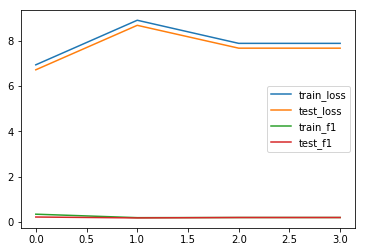

In [2]:
import matplotlib.pyplot as plt
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.plot(train_f1,label='train_f1')
plt.plot(test_f1,label='test_f1')
plt.legend()
plt.show()